# Benzamidine pathway classification (step-by-step)

This notebook classifies stitched PPTIS path trajectories of benzamidine unbinding from trypsin into two pathway classes (A or B).

**Your system specifics:**
- **Pathway A landmarks:** Leu99, Gln175, Gly216
- **Pathway B landmarks:** His57, Ser195, Asp102, 60s loop (residues 60-65)
- **Key H-bond residue:** Asp189
- **Templates:** 2 TRR files for pathway A, 1 TRR file for pathway B
- **Stitched trajectories:** 2-3 frames per XTC at 50 ps intervals (extreme downsampling)

**Feature extraction:**
- Ligand-pocket COM distance
- Orientation angle
- **Continuous distances** to pathway A residues (3 distances)
- **Continuous distances** to pathway B residues (9 distances)
- **H-bond count** to Asp189

**Classification approach:**
- Uses `method='auto'` which selects the best algorithm based on frame count:
  - ≤3 frames → statistics-based (your typical case)
  - 4-10 frames → voting-based
  - >10 frames → DTW
- **Why continuous distances?** Preserves gradient information crucial for sparse data (2-3 frames)

**Workflow:**
1. Define pathway residues (already set for your system)
2. Load templates (2 pathway A + 1 pathway B)
3. Extract features from stitched XTCs
4. Classify each trajectory
5. Save results to CSV

## 1) Imports and basic utilities

In [1]:
# Core libraries
import numpy as np
import math
import os
import csv
import matplotlib.pyplot as plt
from pathlib import Path
# MDAnalysis for trajectory I/O and selections
import MDAnalysis as mda
from MDAnalysis.lib.distances import distance_array
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

## 2) Small DTW utilities (1D and multivariate)

These implementations are straightforward O(N*M) dynamic programming. For moderate-length sequences (hundreds of frames) they are fine. If you need speed, consider `fastdtw` or `dtaidistance` packages.

In [2]:
def dtw_distance_1d(s1, s2, window=None):
    # s1, s2: 1D arrays
    n, m = len(s1), len(s2)
    w = max(n, m) if window is None else int(max(window, abs(n-m)))
    dp = np.full((n+1, m+1), np.inf)
    dp[0,0] = 0.0
    for i in range(1, n+1):
        jmin = max(1, i - w)
        jmax = min(m, i + w)
        for j in range(jmin, jmax+1):
            cost = abs(s1[i-1] - s2[j-1])
            dp[i,j] = cost + min(dp[i-1,j], dp[i,j-1], dp[i-1,j-1])
    return dp[n,m]

def dtw_distance_multivariate(X, Y, metric='euclidean', window=None):
    # X: T x F, Y: M x F
    D = cdist(X, Y, metric=metric)
    n, m = D.shape
    w = max(n, m) if window is None else int(max(window, abs(n-m)))
    dp = np.full((n+1, m+1), np.inf)
    dp[0,0] = 0.0
    for i in range(1, n+1):
        jmin = max(1, i - w)
        jmax = min(m, i + w)
        for j in range(jmin, jmax+1):
            cost = D[i-1, j-1]
            dp[i,j] = cost + min(dp[i-1,j], dp[i,j-1], dp[i-1,j-1])
    return dp[n,m]

## 4) Feature extraction from a trajectory
We'll compute a small, robust feature set per frame: (1) ligand-pocket COM distance, (2) a small contact fingerprint between ligand and a set of pocket/channel residues, (3) a simple orientation proxy (angle). These are compact and usually survive downsampling.

## 4a) Define pathway-specific residues (landmarks)
For each pathway, define residue lists that characterize the path. These are typically residues lining the channel or gate regions that distinguish pathway A from B. The feature extractor will compute minimum distances from ligand to each residue cluster.

In [3]:
# Define pathway-specific residues based on structural analysis
#Benzamidine unbinding from trypsin

# Pathway A residues (defining landmarks)
pathway_A_residues = [
    99,   # Leu99
    175,  # Gln175
    216   # Gly216
]

# Pathway B residues (defining landmarks)
pathway_B_residues = [
    57,   # His57
    195,  # Ser195
    102,  # Asp102
    # 60s loop residues
    60, 61, 62, 63, 64, 65
]

# Key residue for H-bond analysis
asp189_resid = 189  # Asp189 - important for H-bonding

print(f"Pathway A residues: {pathway_A_residues}")
print(f"Pathway B residues: {pathway_B_residues}")
print(f"H-bond donor/acceptor: Asp{asp189_resid}")

Pathway A residues: [99, 175, 216]
Pathway B residues: [57, 195, 102, 60, 61, 62, 63, 64, 65]
H-bond donor/acceptor: Asp189


In [4]:
# Verify feature dimensions for your system
print("Feature vector composition:")
print("=" * 50)
print(f"1. Ligand-pocket COM distance:    1 feature")
print(f"2. Orientation angle:             1 feature")
print(f"3. Distances to pathway A:        {len(pathway_A_residues)} features (Leu99, Gln175, Gly216)")
print(f"4. Distances to pathway B:        {len(pathway_B_residues)} features (His57, Ser195, Asp102, 60s loop)")
print(f"5. H-bonds to Asp189:             1 feature")
print("-" * 50)
print(f"Total features per frame:         {2 + len(pathway_A_residues) + len(pathway_B_residues) + 1}")
print()
print("For 2-3 frame trajectories, feature matrix shape: (2-3, 14)")
print("This gives ~28-42 data points total for classification")

Feature vector composition:
1. Ligand-pocket COM distance:    1 feature
2. Orientation angle:             1 feature
3. Distances to pathway A:        3 features (Leu99, Gln175, Gly216)
4. Distances to pathway B:        9 features (His57, Ser195, Asp102, 60s loop)
5. H-bonds to Asp189:             1 feature
--------------------------------------------------
Total features per frame:         15

For 2-3 frame trajectories, feature matrix shape: (2-3, 14)
This gives ~28-42 data points total for classification


## 4b) H-bond detection: Distance + Angle vs Distance-only

**Why distance alone is insufficient:**
- Many atom pairs can be within 3.5 Å without forming an H-bond
- True H-bonds have directionality: the D-H···A angle should be ~180° (linear)
- Distance-only detection gives false positives from non-bonding contacts

**Proper H-bond geometry:**
1. **Distance criterion**: D-H···A distance < 3.5 Å (0.35 nm)
2. **Angle criterion**: D-H···A angle > 120-150° (measures linearity)
   - 180° = perfectly linear (ideal)
   - 120° = minimum for H-bond character
   - < 120° = likely just a contact, not an H-bond

**Implementation approaches:**

1. **With explicit hydrogens (BEST)** ⭐
   - Locate H atoms bonded to donor heavy atoms (N, O)
   - Measure D-H···A angle directly
   - Most accurate but requires hydrogens in structure
   - Used by MDAnalysis.analysis.hydrogenbonds.HydrogenBondAnalysis

2. **Without explicit hydrogens (FALLBACK)**
   - Use heavy atom distance D···A only
   - Less accurate but works with reduced structures
   - Assumes ideal geometry
   - Current implementation tries explicit H first, falls back to distance-only

## 4c) Note on time vs frame indexing

**Why we use frame indices instead of time values:**

For stitched PPTIS trajectories concatenated from multiple segments (trajB + trajF):
- **Time values are discontinuous**: Each segment comes from a separate simulation with its own time origin
- **Time values may overlap**: trajB and trajF can have conflicting time stamps
- **Frame indices are consistent**: Sequential frame numbers (0, 1, 2, ...) work reliably regardless of source

**Example issue with time indexing:**
```
Segment 1 (trajB): frames at t = 100, 150, 200 ps
Segment 2 (trajF): frames at t = 50, 100, 150 ps
Stitched XTC:      frames 0, 1, 2, 3, 4, 5 (consistent)
                   times = 100, 150, 200, 50, 100, 150 ps (discontinuous!)
```

**Solution:** Use `ts.frame` (0-based frame index) instead of `ts.time` (simulation time in ps)

This only affects plotting/visualization - features are extracted per-frame and classification works identically.

In [5]:
def extract_features(universe, ligand_sel='resname BEN', pocket_sel='resid 190 191 192 195 213 215 216 219 220 224 228 247 and protein',
                     pathway_A_resids=None, pathway_B_resids=None, 
                     hbond_resid=189, hbond_distance=0.35, hbond_angle=120):
    """
    Extract features from trajectory for pathway classification.
    
    Features include:
    1. Ligand-pocket COM distance
    2. Orientation angle (ligand->pocket vector vs reference axis)
    3. Minimum distances to pathway A landmark residues (continuous)
    4. Minimum distances to pathway B landmark residues (continuous)
    5. Number of H-bonds between ligand and specified residue (e.g., Asp189)
    
    Parameters:
    -----------
    universe : MDAnalysis.Universe
    ligand_sel : str, ligand selection string
    pocket_sel : str, pocket selection string
    pathway_A_resids : list of int, pathway A landmark residues
    pathway_B_resids : list of int, pathway B landmark residues
    hbond_resid : int, residue for H-bond counting (default 189 for Asp189)
    hbond_distance : float, H-bond distance cutoff in nm (default 0.35 = 3.5 Å)
    hbond_angle : float, H-bond angle cutoff in degrees (default 120°)
                         measures D-H···A angle where 180° is perfectly linear
    
    Returns:
    --------
    frames : array, frame indices (0-based) for each frame
             Note: uses frame index instead of time because stitched XTCs from 
             concatenated segments have inconsistent/discontinuous time values
    feats : array (T x F), feature matrix where each row is a frame
    """
    lig = universe.select_atoms(ligand_sel)
    pocket = universe.select_atoms(pocket_sel)
    
    # H-bond partner residue (e.g., Asp189)
    hbond_res = universe.select_atoms(f'resid {hbond_resid} and protein')
    
    # Pathway landmark residues - use distances not binary contacts
    pathA_groups = []
    if pathway_A_resids:
        for resid in pathway_A_resids:
            sel = universe.select_atoms(f'resid {resid} and protein')
            if len(sel) > 0:
                pathA_groups.append(sel)
    
    pathB_groups = []
    if pathway_B_resids:
        for resid in pathway_B_resids:
            sel = universe.select_atoms(f'resid {resid} and protein')
            if len(sel) > 0:
                pathB_groups.append(sel)
    
    times = []
    feats = []
    
    for ts in universe.trajectory:
        # Use frame index instead of time (times are unreliable for concatenated segments)
        times.append(ts.frame)
        lig_com = lig.center_of_mass()
        pocket_com = pocket.center_of_mass()
        d_com = np.linalg.norm(lig_com - pocket_com)
        
        # Orientation angle: vector ligand->pocket vs reference axis
        axis = np.array([1.0, 0.0, 0.0])
        v = (pocket_com - lig_com)
        normv = np.linalg.norm(v) if np.linalg.norm(v) > 0 else 1.0
        angle = math.acos(np.clip(np.dot(v, axis) / (normv * np.linalg.norm(axis)), -1.0, 1.0))
        
        # Distance to pathway landmark residues (continuous, in nm)
        def distances_to(res_groups):
            dists = []
            for grp in res_groups:
                if len(grp) == 0:
                    dists.append(999.0)  # large distance for missing residues
                    continue
                D = distance_array(lig.positions, grp.positions)
                minD = D.min() if D.size else 999.0
                dists.append(minD)
            return np.array(dists, dtype=float)
        
        dA = distances_to(pathA_groups)
        dB = distances_to(pathB_groups)
        
        # H-bond counting with proper geometric criteria (distance + angle)
        n_hbonds = 0
        if len(hbond_res) > 0 and len(lig) > 0:
            # Select potential donors and acceptors with explicit hydrogens
            # Ligand donors: N-H or O-H groups
            lig_donors_heavy = lig.select_atoms('(name N* or name O*) and not name H*')
            lig_acceptors = lig.select_atoms('name N* or name O*')
            
            # Residue groups (Asp189 has carboxyl oxygens as acceptors, can also be donors)
            res_donors_heavy = hbond_res.select_atoms('(name N* or name O*) and not name H*')
            res_acceptors = hbond_res.select_atoms('name N* or name O*')
            
            # Try to find hydrogens bonded to heavy atoms
            try:
                lig_hydrogens = lig.select_atoms('name H*')
                res_hydrogens = hbond_res.select_atoms('name H*')
                has_hydrogens = len(lig_hydrogens) > 0 or len(res_hydrogens) > 0
            except:
                has_hydrogens = False
            
            if has_hydrogens:
                # Method 1: Use explicit hydrogens (more accurate)
                # Check ligand as donor -> residue as acceptor
                for donor_heavy in lig_donors_heavy:
                    # Find hydrogens bonded to this donor (within 0.12 nm)
                    D_DH = distance_array(donor_heavy.position.reshape(1,-1), lig_hydrogens.positions)
                    bonded_H_idx = np.where(D_DH[0] < 1.2)[0]  # 0.12 nm = 1.2 Å
                    
                    for h_idx in bonded_H_idx:
                        h_pos = lig_hydrogens[h_idx].position
                        # Check distance H···A
                        D_HA = np.linalg.norm(res_acceptors.positions - h_pos.reshape(1,-1), axis=1)
                        close_acceptors = np.where(D_HA < hbond_distance * 10)[0]  # convert nm to Å
                        
                        for acc_idx in close_acceptors:
                            # Calculate D-H···A angle
                            vec_DH = h_pos - donor_heavy.position
                            vec_HA = res_acceptors[acc_idx].position - h_pos
                            
                            cos_angle = np.dot(vec_DH, vec_HA) / (np.linalg.norm(vec_DH) * np.linalg.norm(vec_HA) + 1e-10)
                            angle_deg = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))
                            
                            if angle_deg >= hbond_angle:
                                n_hbonds += 1
                
                # Check residue as donor -> ligand as acceptor
                for donor_heavy in res_donors_heavy:
                    D_DH = distance_array(donor_heavy.position.reshape(1,-1), res_hydrogens.positions)
                    bonded_H_idx = np.where(D_DH[0] < 1.2)[0]
                    
                    for h_idx in bonded_H_idx:
                        h_pos = res_hydrogens[h_idx].position
                        D_HA = np.linalg.norm(lig_acceptors.positions - h_pos.reshape(1,-1), axis=1)
                        close_acceptors = np.where(D_HA < hbond_distance * 10)[0]
                        
                        for acc_idx in close_acceptors:
                            vec_DH = h_pos - donor_heavy.position
                            vec_HA = lig_acceptors[acc_idx].position - h_pos
                            
                            cos_angle = np.dot(vec_DH, vec_HA) / (np.linalg.norm(vec_DH) * np.linalg.norm(vec_HA) + 1e-10)
                            angle_deg = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))
                            
                            if angle_deg >= hbond_angle:
                                n_hbonds += 1
            else:
                # Method 2: No explicit hydrogens - use heavy atom approximation
                # Assume hydrogen is along D-A axis (less accurate but works without H)
                # Check all donor-acceptor pairs
                if len(lig_donors_heavy) > 0 and len(res_acceptors) > 0:
                    D = distance_array(lig_donors_heavy.positions, res_acceptors.positions)
                    # Count pairs within distance cutoff
                    n_hbonds += np.sum(D < hbond_distance * 10)  # convert nm to Å
                
                if len(res_donors_heavy) > 0 and len(lig_acceptors) > 0:
                    D = distance_array(res_donors_heavy.positions, lig_acceptors.positions)
                    n_hbonds += np.sum(D < hbond_distance * 10)
        
        # Concatenate all features
        # Order: [COM_dist, angle, distances_to_A, distances_to_B, n_hbonds]
        feat = np.concatenate([[d_com, angle], dA, dB, [n_hbonds]])
        feats.append(feat)
    
    feats = np.vstack(feats) if len(feats) else np.empty((0,0))
    return np.array(times), feats

## 5) Load templates (path A / B) and build reference feature sequences
Provide paths to representative template XTCs (these could be higher-frequency original runs). We'll compute features for each template and keep them as sequences for DTW matching.

In [12]:
# Template file paths - update these to your actual template files
template_top = '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/trypsin-benzos/gromacs_input_latest/conf_nw.gro'  # topology file (use local copy if GVFS)

# You have 2 templates for pathway A and 1 for pathway B
template_A1_xtc = '/run/user/1001/gvfs/sftp:host=172.18.15.4,user=elias/mnt/external/init_paths/load/915_ss.xtc'  # pathway A template 1
template_A2_xtc = '/run/user/1001/gvfs/sftp:host=172.18.15.4,user=elias/mnt/external/init_paths/load/948_ss.xtc'  # pathway A template 2
template_B_xtc = '/run/user/1001/gvfs/sftp:host=172.18.15.4,user=elias/mnt/external/init_paths/load/967_ss.xtc'    # pathway B template

# Directory for template feature cache
template_cache_dir = Path('/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/tistools/test/template_features_cache')
template_cache_dir.mkdir(exist_ok=True)

# Load template features
def load_template_features(top, traj, ligand_sel='resname BEN', pocket_sel=None, 
                          pathwayA=None, pathwayB=None, hbond_resid=189,
                          save=True, load_cached=True):
    """
    Load and extract features from a template trajectory.
    
    Parameters:
    -----------
    top : str, path to topology file
    traj : str, path to trajectory file
    ligand_sel : str, ligand selection
    pocket_sel : str, pocket selection
    pathwayA : list, pathway A residue IDs
    pathwayB : list, pathway B residue IDs
    hbond_resid : int, H-bond residue ID
    save : bool, if True save extracted features to cache file
    load_cached : bool, if True try to load from cache before extracting
    
    Returns:
    --------
    frames : array, frame indices
    feats : array, feature matrix
    """
    import pickle
    # Generate cache filename based on trajectory path
    traj_name = Path(traj).stem
    cache_file = template_cache_dir / f'{traj_name}_template.pkl'
    
    # Try to load from cache if requested
    if load_cached and cache_file.exists():
        try:
            with open(cache_file, 'rb') as fh:
                cached_data = pickle.load(fh)
                frames = cached_data['frames']
                feats = cached_data['feats']
            print(f'✓ Loaded cached template features from {cache_file.name}')
            return frames, feats
        except Exception as e:
            print(f'⚠️  Cache load failed: {e}, extracting features...')
    
    # Extract features if not loaded from cache
    if not (os.path.exists(top) and os.path.exists(traj)):
        raise FileNotFoundError(f'Missing template files: {top} or {traj}')
    
    print(f'Loading template: {traj}')
    u = mda.Universe(top, traj)
    tsel = pocket_sel or 'resid 190 191 192 195 213 215 216 219 220 224 228 247 and protein'
    print(f'Using pocket selection: {tsel}')
    frames, feats = extract_features(u, ligand_sel=ligand_sel, pocket_sel=tsel, 
                                   pathway_A_resids=pathwayA, pathway_B_resids=pathwayB,
                                   hbond_resid=hbond_resid)
    
    # Save to cache if requested
    if save:
        try:
            with open(cache_file, 'wb') as fh:
                pickle.dump({'frames': frames, 'feats': feats}, fh)
            print(f'✓ Saved template features to {cache_file.name}')
        except Exception as e:
            print(f'⚠️  Cache save failed: {e}')
    
    return frames, feats

# Load all templates with caching enabled
# Set load_cached=False to force re-extraction from XTC files
print("Loading template features (with caching)...")
print("=" * 60)

ss = False
ll = True

tA1_times, tA1_feats = load_template_features(
    template_top, template_A1_xtc, 
    pathwayA=pathway_A_residues, 
    pathwayB=pathway_B_residues,
    save=ss,
    load_cached=ll
)

tA2_times, tA2_feats = load_template_features(
    template_top, template_A2_xtc,
    pathwayA=pathway_A_residues, 
    pathwayB=pathway_B_residues,
    save=ss,
    load_cached=ll
)

tB_times, tB_feats = load_template_features(
    template_top, template_B_xtc,
    pathwayA=pathway_A_residues, 
    pathwayB=pathway_B_residues,
    save=ss,
    load_cached=ll
)

# Combine pathway A templates by concatenating (increases template diversity)
# Note: tA1_times, tA2_times, tA_times are actually frame indices (0-based), not time values
tA_feats = np.vstack([tA1_feats, tA2_feats])
tA_times = np.concatenate([tA1_times, tA2_times])

print("=" * 60)
print("✓ Template loading complete!")
print(f"  Pathway A (combined): {len(tA_times)} frames, {tA_feats.shape[1]} features")
print(f"    - Template A1: {len(tA1_times)} frames")
print(f"    - Template A2: {len(tA2_times)} frames")
print(f"  Pathway B: {len(tB_times)} frames, {tB_feats.shape[1]} features")

Loading template features (with caching)...
✓ Loaded cached template features from 915_ss_template.pkl
✓ Loaded cached template features from 948_ss_template.pkl
✓ Loaded cached template features from 967_ss_template.pkl
✓ Template loading complete!
  Pathway A (combined): 50153 frames, 15 features
    - Template A1: 29823 frames
    - Template A2: 20330 frames
  Pathway B: 3897 frames, 15 features


## 6) Classification function
We provide two classification routes: (A) DTW on multivariate features (works without interpolation), (B) resample to common time grid and compare using DTW or L2. We'll also include the softmin scoring approach (soft-fuzzy assignment).

## 5a) Scoring methods overview

**Currently implemented methods:**

1. **DTW (Dynamic Time Warping) - multivariate**
   - Compares feature trajectories allowing for time warping/stretching
   - Robust to different sampling rates and speeds
   - Returns distance to each template; assigns label based on minimum
   - Window parameter controls allowed warping (smaller = faster but less flexible)

2. **Softmin scoring (fuzzy assignment)**
   - Computes per-frame soft-minimum distance to template using log-sum-exp
   - Averages across trajectory for global score
   - More robust to outlier frames than hard assignment
   - λ parameter controls "softness" (smaller = softer, more fuzzy)

**Alternative methods you can implement:**

3. **Hausdorff distance**
   - Measures maximum deviation between two sets
   - Good for detecting worst-case differences
   - Implementation: `from scipy.spatial.distance import directed_hausdorff`

4. **Fréchet distance (discrete)**
   - "Dog-leash" distance - measures similarity with monotonic matching
   - Better for ordered trajectories than Hausdorff
   - Available in packages like `similaritymeasures`

5. **Hidden Markov Models (HMMs)**
   - Model each pathway as an HMM trained on template data
   - Classify by computing likelihood under each model
   - Use `hmmlearn` package

6. **Simple Euclidean after alignment**
   - Interpolate both to same time grid, compute L2 distance
   - Fast but requires good time alignment
   - Best when sampling rates are similar

7. **Path signature methods**
   - Use rough path theory / signature transform
   - Captures geometric properties independent of parameterization
   - See `esig` or `signatory` packages

8. **Neural network embeddings**
   - Train autoencoder/VAE on template paths
   - Classify in latent space
   - Best when you have many labeled examples

## 5b) Dealing with extreme downsampling (2-3 frames per trajectory)

**Your situation:** Stitched XTCs have 2-3 frames at 50 ps intervals, while full trajectories have frames every 20 fs.
- Downsampling factor: ~2500x (50 ps / 0.02 ps)
- Available points per trajectory: 2-3 frames
- This is **too sparse for DTW** to capture trajectory dynamics meaningfully

**Why DTW struggles here:**
- DTW needs sufficient sampling to capture trajectory shape/dynamics
- With only 2-3 points, you're essentially comparing discrete "snapshots" rather than paths
- The warping flexibility of DTW provides no benefit with so few points
- Computational cost of DTW is wasted on 2-3 point comparisons

**Recommended alternatives for sparse data:**

1. **Simple feature statistics (BEST for 2-3 frames)** ⭐
   - Compute mean/min/max of each feature across the 2-3 frames
   - Compare summary statistics to template statistics using simple distance
   - Fast, interpretable, and appropriate for sparse data
   - Example: mean ligand-pocket distance, min distance to pathway A residues, etc.

2. **Direct frame-to-template matching**
   - For each of your 2-3 frames, find nearest frame in template
   - Average the distances across your frames
   - Essentially k-NN in feature space
   - Better than DTW when trajectory order doesn't matter

3. **Endpoint analysis**
   - Focus on initial and final states (frame 1 and frame 2-3)
   - Compare start/end feature vectors to pathway templates
   - Logical for PPTIS where fragments represent transitions

4. **Voting/ensemble approach**
   - Classify each individual frame independently
   - Final label = majority vote across 2-3 frames
   - More robust to single outlier frames

**What to avoid:**
- ❌ DTW (overkill and misleading for 2-3 points)
- ❌ Interpolation (creates artificial data between sparse points)
- ❌ Softmin with trajectory averaging (loses frame-level information)

In [13]:
# Implementations for sparse trajectory classification (2-3 frames)

def classify_sparse_statistics(feats, templateA_feats, templateB_feats):
    """
    Best for 2-3 frame trajectories. Compares feature statistics.
    
    Computes mean across trajectory frames and compares to template means.
    """
    # Summary statistics for segment
    seg_mean = feats.mean(axis=0)
    seg_std = feats.std(axis=0) if len(feats) > 1 else np.zeros_like(seg_mean)
    
    # Template statistics
    tA_mean = templateA_feats.mean(axis=0)
    tB_mean = templateB_feats.mean(axis=0)
    
    # Distance to template means (weighted by inverse template variance for robustness)
    tA_std = templateA_feats.std(axis=0) + 1e-6
    tB_std = templateB_feats.std(axis=0) + 1e-6
    
    # Mahalanobis-like distance (weighted by template variance)
    dA = np.sqrt(np.sum(((seg_mean - tA_mean) / tA_std) ** 2))
    dB = np.sqrt(np.sum(((seg_mean - tB_mean) / tB_std) ** 2))
    
    label = 'A' if dA < dB else 'B'
    margin = abs(dA - dB)
    confidence = margin / (dA + dB + 1e-12)
    
    return label, confidence, dA, dB

def classify_frame_voting(feats, templateA_feats, templateB_feats):
    """
    Classify each frame independently, then vote. Good for 2-3 frames.
    """
    votes = []
    distances_A = []
    distances_B = []
    
    for frame_feat in feats:
        # Find distance to nearest template frame
        dA = np.min(np.linalg.norm(templateA_feats - frame_feat, axis=1))
        dB = np.min(np.linalg.norm(templateB_feats - frame_feat, axis=1))
        
        distances_A.append(dA)
        distances_B.append(dB)
        votes.append('A' if dA < dB else 'B')
    
    # Majority vote
    vote_A = votes.count('A')
    vote_B = votes.count('B')
    label = 'A' if vote_A > vote_B else ('B' if vote_B > vote_A else 'Uncertain')
    
    # Average distances
    avg_dA = np.mean(distances_A)
    avg_dB = np.mean(distances_B)
    confidence = abs(vote_A - vote_B) / len(votes)
    
    return label, confidence, avg_dA, avg_dB

def classify_endpoint_analysis(feats, templateA_feats, templateB_feats):
    """
    Focus on start and end frames. Good for PPTIS transition fragments.
    """
    if len(feats) < 2:
        # Single frame - compare to template means
        return classify_sparse_statistics(feats, templateA_feats, templateB_feats)
    
    start_frame = feats[0]
    end_frame = feats[-1]
    
    # Distance of start frame to template starts
    tA_start_dist = np.min(np.linalg.norm(templateA_feats[:10] - start_frame, axis=1))
    tB_start_dist = np.min(np.linalg.norm(templateB_feats[:10] - start_frame, axis=1))
    
    # Distance of end frame to template ends
    tA_end_dist = np.min(np.linalg.norm(templateA_feats[-10:] - end_frame, axis=1))
    tB_end_dist = np.min(np.linalg.norm(templateB_feats[-10:] - end_frame, axis=1))
    
    # Combined score (weighted average)
    dA = 0.5 * tA_start_dist + 0.5 * tA_end_dist
    dB = 0.5 * tB_start_dist + 0.5 * tB_end_dist
    
    label = 'A' if dA < dB else 'B'
    margin = abs(dA - dB)
    confidence = margin / (dA + dB + 1e-12)
    
    return label, confidence, dA, dB

In [14]:
# Example implementations of alternative scoring methods

def hausdorff_distance(X, Y):
    """Hausdorff distance between two trajectories (max-min distance)"""
    from scipy.spatial.distance import directed_hausdorff
    d_XY = directed_hausdorff(X, Y)[0]
    d_YX = directed_hausdorff(Y, X)[0]
    return max(d_XY, d_YX)

def frechet_distance(X, Y):
    """Discrete Fréchet distance (requires similaritymeasures package)"""
    try:
        from similaritymeasures import frechet_dist
        return frechet_dist(X, Y)
    except ImportError:
        print("Install: pip install similaritymeasures")
        return None

def euclidean_after_interpolation(times1, X, times2, Y):
    """Interpolate to common grid and compute L2 distance"""
    from scipy.interpolate import interp1d
    # Find common time range
    t_min = max(times1.min(), times2.min())
    t_max = min(times1.max(), times2.max())
    t_common = np.linspace(t_min, t_max, 100)
    # Interpolate
    X_interp = np.vstack([interp1d(times1, X[:,i], bounds_error=False, fill_value='extrapolate')(t_common)
                          for i in range(X.shape[1])]).T
    Y_interp = np.vstack([interp1d(times2, Y[:,i], bounds_error=False, fill_value='extrapolate')(t_common)
                          for i in range(Y.shape[1])]).T
    return np.linalg.norm(X_interp - Y_interp)

# These are optional - uncomment to use in classify_segment

In [15]:
def softmin_z(X, path_feats, lam=1.0):
    # X: T x F, path_feats: M x F
    D2 = cdist(X, path_feats, metric='sqeuclidean')  # T x M
    # per-frame soft-min (log-sum-exp of negative distances)
    z_per_frame = - (1.0/lam) * np.log(np.exp(-lam * D2).sum(axis=1))
    return z_per_frame

def classify_segment(feats, templateA_feats, templateB_feats, method='auto', window=None, lam=1.0, eps=1e-6):
    """
    Classify a trajectory segment against two templates.
    
    Parameters:
    -----------
    feats : array (T x F) - trajectory features to classify
    templateA_feats : array (M_A x F) - pathway A template features
    templateB_feats : array (M_B x F) - pathway B template features
    method : str - classification method:
        'auto' : automatically choose based on trajectory length (default)
        'statistics' : compare feature means (best for 2-3 frames)
        'voting' : per-frame nearest neighbor voting (good for 2-3 frames)
        'endpoint' : compare start/end states (good for PPTIS fragments)
        'dtw' : Dynamic Time Warping (only good for >10 frames)
        'softmin' : soft-minimum scoring (only good for >10 frames)
    window : int - DTW window size (only used for method='dtw')
    lam : float - softmin lambda parameter (only used for method='softmin')
    eps : float - threshold for uncertain classification
    
    Returns:
    --------
    label : str - 'A', 'B', or 'Uncertain'
    confidence : float - confidence score
    dA : float - distance/score to template A
    dB : float - distance/score to template B
    """
    T = len(feats)
    
    # Auto-select method based on trajectory length
    if method == 'auto':
        if T <= 3:
            method = 'statistics'  # Best for very sparse data
        elif T <= 10:
            method = 'voting'  # Good for sparse data
        else:
            method = 'dtw'  # Use DTW for longer trajectories
    
    # Sparse data methods (2-10 frames)
    if method == 'statistics':
        return classify_sparse_statistics(feats, templateA_feats, templateB_feats)
    elif method == 'voting':
        return classify_frame_voting(feats, templateA_feats, templateB_feats)
    elif method == 'endpoint':
        return classify_endpoint_analysis(feats, templateA_feats, templateB_feats)
    
    # Dense trajectory methods (>10 frames)
    elif method == 'dtw':
        dA = dtw_distance_multivariate(feats, templateA_feats, window=window)
        dB = dtw_distance_multivariate(feats, templateB_feats, window=window)
        label = 'A' if dA < dB else 'B'
        margin = abs(dA - dB)
        if margin < eps:
            label = 'Uncertain'
        confidence = margin / (dA + dB + 1e-12)
        return label, confidence, dA, dB
    
    elif method == 'softmin':
        zA = softmin_z(feats, templateA_feats, lam=lam)
        zB = softmin_z(feats, templateB_feats, lam=lam)
        score = zA.mean() - zB.mean()
        if abs(score) < eps:
            label = 'Uncertain'
        else:
            label = 'A' if score < 0 else 'B'
        confidence = abs(score) / (np.std(np.concatenate([zA, zB])) + 1e-12)
        return label, confidence, score, None
    
    else:
        raise ValueError(f'Unknown method: {method}')

## 7) Run classification over stitched paths directory
Update the paths below to the directory containing your stitched `<id>.xtc` files and the associated topology. The code will iterate, extract features, and classify each file.

**Feature caching:** Features are automatically saved to `features_cache/` directory as pickle files. On subsequent runs, cached features are loaded instead of re-computing from XTC files (much faster!). Delete the cache directory to force re-computation.

**Batch processing:** Trajectories are processed in batches (default: 100 per batch) with memory cleanup after each batch. This prevents memory buildup when processing thousands of files. Adjust `BATCH_SIZE` based on your RAM availability.

## 6a) Load pre-computed features (optional)

If you've already run the classification once and features were cached, you can load them here to inspect or re-classify without re-computing features from XTC files.

**Features are automatically cached** during classification in `features_cache/` directory as pickle files.

In [16]:
import pickle

# Load all cached features from a directory
def load_all_features(cache_dir='features_cache'):
    """
    Load all pre-computed features from cache directory.
    
    Returns:
    --------
    features_dict : dict
        Dictionary mapping trajectory IDs to (frames, feats) tuples
    """
    cache_path = Path(cache_dir)
    if not cache_path.exists():
        print(f'Cache directory {cache_dir} not found.')
        return {}
    
    features_dict = {}
    cache_files = sorted(cache_path.glob('*_features.pkl'))
    
    print(f'Loading {len(cache_files)} cached feature files...')
    for cache_file in cache_files:
        traj_id = cache_file.stem.replace('_features', '')
        try:
            with open(cache_file, 'rb') as fh:
                data = pickle.load(fh)
                features_dict[traj_id] = (data['frames'], data['feats'])
        except Exception as e:
            print(f'  ⚠️  Failed to load {cache_file.name}: {e}')
    
    print(f'✓ Loaded features for {len(features_dict)} trajectories')
    return features_dict

# Example: load all features
# features_dict = load_all_features('features_cache')
# 
# # Inspect a specific trajectory
# if '144' in features_dict:
#     frames_144, feats_144 = features_dict['144']
#     print(f'Trajectory 144: {len(frames_144)} frames, {feats_144.shape[1]} features')
#     print(f'Feature vector example (frame 0): {feats_144[0]}')

In [20]:
from IPython.display import clear_output
import gc  # For garbage collection / memory management

# Directory containing stitched path XTCs (each named like 144.xtc)


stitched_dir = Path('/run/user/1001/gvfs/sftp:host=172.18.15.4,user=elias/mnt/external/infrepptis_try_benz_subcycle_10_latest/infrepptis4/load')  # update to your base load dir if needed

topology = '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/trypsin-benzos/gromacs_input_latest/conf.gro'  # update to local copied topology if GVFS paths are used

# Output directory for cached features
features_cache_dir = Path('features_cache')
features_cache_dir.mkdir(exist_ok=True)

# Batch processing settings
BATCH_SIZE = 500  # Process this many trajectories before flushing memory
                  # Adjust based on your RAM: 50 for low memory, 200+ for high memory

# Choose classification method:
# 'auto' - automatically picks best method based on number of frames (RECOMMENDED)
# 'statistics' - feature statistics (best for 2-3 frames)
# 'voting' - per-frame voting (good for 2-10 frames)
# 'endpoint' - start/end comparison (good for PPTIS)
# 'dtw' - Dynamic Time Warping (only for >10 frames)
classification_method = 'auto'  # Recommended for mixed trajectory lengths

# If you haven't loaded templates, stop here and create tA_feats / tB_feats first
if 'tA_feats' not in globals() or 'tB_feats' not in globals():
    print('⚠️  Template features not found in namespace.')
    print('Please load templates first (see cell above):')
    print('  - tA_feats should combine both pathway A templates (A1 + A2)')
    print('  - tB_feats should contain pathway B template')
else:
    
    # Get all subdirectories first (each contains one XTC file)
    print(f'Looking for trajectory directories in: {stitched_dir}')
    subdirs = sorted([subdir for subdir in stitched_dir.iterdir() if subdir.is_dir()])
    print(f"Found {len(subdirs)} subdirectories to scan")
    
    results = []
    
    # Track method usage statistics
    method_counts = {}
    
    # Calculate number of batches based on subdirectories
    n_batches = (len(subdirs) + BATCH_SIZE - 1) // BATCH_SIZE  # Ceiling division
    
    print(f"Processing in {n_batches} batches...")
    print(f"Batch size: {BATCH_SIZE} trajectories")
    print(f"Using pathway residues:")
    print(f"  A: {pathway_A_residues if 'pathway_A_residues' in globals() else 'NOT DEFINED'}")
    print(f"  B: {pathway_B_residues if 'pathway_B_residues' in globals() else 'NOT DEFINED'}")
    print(f"  H-bond residue: {asp189_resid if 'asp189_resid' in globals() else 189}")
    print()
    
    # Process subdirectories in batches
    for batch_idx in range(n_batches):
        batch_start = batch_idx * BATCH_SIZE
        batch_end = min((batch_idx + 1) * BATCH_SIZE, len(subdirs))
        batch_subdirs = subdirs[batch_start:batch_end]
        
        # Find XTC files in this batch of subdirectories
        batch_files = []
        for subdir in batch_subdirs:
            batch_files.extend(list(subdir.glob('*.xtc')))
        batch_files = sorted(batch_files)
        
        print(f"\n{'='*70}")
        print(f"BATCH {batch_idx + 1}/{n_batches}: Processing directories {batch_start + 1}-{batch_end} of {len(subdirs)}")
        print(f"Found {len(batch_files)} XTC files in this batch")
        print(f"{'='*70}\n")
    
        for idx, f in enumerate(batch_files, start=1):
            clear_output(wait=True)
            
            # Calculate global index for progress reporting
            global_idx = batch_start + idx
            
            # Print progress
            print(f"Batch {batch_idx + 1}/{n_batches}")
            print(f"Processing {idx}/{len(batch_files)} in current batch (file {global_idx} overall)")
            print(f"Current file: {f.name}")
            print(f"Pathway A: {sum(1 for r in results if r['label']=='A')} | "
                f"Pathway B: {sum(1 for r in results if r['label']=='B')} | "
                f"Uncertain: {sum(1 for r in results if r['label']=='Uncertain')} | "
                f"Errors: {sum(1 for r in results if r['label']=='Error')}")
            
            try:
                u = mda.Universe(topology, str(f))
            except Exception as e:
                print(f'❌ Could not open {f}: {e}')
                results.append({
                    'file': str(f), 
                    'n_frames': 0,
                    'method': 'error',
                    'label': 'Error', 
                    'confidence': 0.0, 
                    'dA': None, 
                    'dB': None
                })
                continue
            
            n_frames = len(u.trajectory)
            
            # Check if features are already cached
            # Use trajectory file stem as cache key (e.g., "144" from "144.xtc")
            cache_key = f.stem
            cache_file = features_cache_dir / f'{cache_key}_features.pkl'
            
            if cache_file.exists():
                # Load cached features
                try:
                    with open(cache_file, 'rb') as fh:
                        cached_data = pickle.load(fh)
                        frames = cached_data['frames']
                        feats = cached_data['feats']
                    print(f'  ✓ Loaded cached features from {cache_file.name}')
                except Exception as e:
                    print(f'  ⚠️  Cache load failed: {e}, recomputing...')
                    # Extract features with your specific pathway residues
                    frames, feats = extract_features(
                        u, 
                        pathway_A_resids=pathway_A_residues if 'pathway_A_residues' in globals() else None,
                        pathway_B_resids=pathway_B_residues if 'pathway_B_residues' in globals() else None,
                        hbond_resid=asp189_resid if 'asp189_resid' in globals() else 189
                    )
                    # Save to cache
                    try:
                        with open(cache_file, 'wb') as fh:
                            pickle.dump({'frames': frames, 'feats': feats}, fh)
                    except Exception as e:
                        print(f'  ⚠️  Cache save failed: {e}')
            else:
                # Extract features with your specific pathway residues
                frames, feats = extract_features(
                    u, 
                    pathway_A_resids=pathway_A_residues if 'pathway_A_residues' in globals() else None,
                    pathway_B_resids=pathway_B_residues if 'pathway_B_residues' in globals() else None,
                    hbond_resid=asp189_resid if 'asp189_resid' in globals() else 189
                )
                # Save to cache for future use
                try:
                    with open(cache_file, 'wb') as fh:
                        pickle.dump({'frames': frames, 'feats': feats}, fh)
                    print(f'  ✓ Saved features to {cache_file.name}')
                except Exception as e:
                    print(f'  ⚠️  Cache save failed: {e}')
            
            # Standardize features to handle different scales (distances vs angles vs counts)
            scaler = StandardScaler()
            if feats.size == 0:
                print(f'⚠️  No frames for {f} - skipping')
                results.append({
                    'file': str(f), 
                    'n_frames': n_frames,
                    'method': 'error',
                    'label': 'Error', 
                    'confidence': 0.0, 
                    'dA': None, 
                    'dB': None
                })
                continue
            feats_scaled = scaler.fit_transform(feats)
            
            # Classify using selected method (auto-selects based on frame count)
            try:
                label, confidence, dA, dB = classify_segment(
                    feats_scaled, 
                    scaler.transform(tA_feats), 
                    scaler.transform(tB_feats), 
                    method=classification_method
                )
                
                # Determine which method was actually used (for auto mode)
                if classification_method == 'auto':
                    if n_frames <= 3:
                        used_method = 'statistics'
                    elif n_frames <= 10:
                        used_method = 'voting'
                    else:
                        used_method = 'dtw'
                else:
                    used_method = classification_method
                
                method_counts[used_method] = method_counts.get(used_method, 0) + 1
                
            except Exception as e:
                print(f'❌ Classification failed for {f}: {e}')
                label, confidence, dA, dB = ('Error', 0.0, None, None)
                used_method = 'error'
            
            results.append({
                'file': str(f), 
                'n_frames': n_frames,
                'method': used_method,
                'label': label, 
                'confidence': confidence, 
                'dA': dA, 
                'dB': dB
            })
            
            # Explicit cleanup for this trajectory
            del u, frames, feats, feats_scaled
            if 'scaler' in locals():
                del scaler
        
        # End of batch: Save results and cleanup memory
        print(f"\n🧹 Batch {batch_idx + 1}/{n_batches} complete - saving results and flushing memory...")
        
        # Save results to CSV after each batch (incremental save)
        out_csv = 'classification_results.csv'
        if results:  # Only save if we have results
            with open(out_csv, 'w', newline='') as fh:
                w = csv.DictWriter(fh, fieldnames=list(results[0].keys()))
                w.writeheader()
                w.writerows(results)
            print(f"   ✓ Saved {len(results)} results to {out_csv}")
        
        gc.collect()  # Force garbage collection
        print(f"   Memory released. {len(results)} trajectories processed so far.\n")
    
    # Clear and show final summary
    clear_output(wait=True)
    
    # Final save to CSV (already done in last batch, but shown here for clarity)
    out_csv = 'classification_results.csv'
    if results:
        with open(out_csv, 'w', newline='') as fh:
            w = csv.DictWriter(fh, fieldnames=list(results[0].keys()))
            w.writeheader()
            w.writerows(results)
    
    print(f'✓ Saved results to {out_csv}')
    print(f'\n📊 Classification summary:')
    print(f'  Total trajectories: {len(results)}')
    print(f'  Methods used: {method_counts}')
    print(f'  Label distribution:')
    print(f'    Pathway A: {sum(1 for r in results if r["label"]=="A")}')
    print(f'    Pathway B: {sum(1 for r in results if r["label"]=="B")}')
    print(f'    Uncertain: {sum(1 for r in results if r["label"]=="Uncertain")}')
    print(f'    Errors: {sum(1 for r in results if r["label"]=="Error")}')

✓ Saved results to classification_results.csv

📊 Classification summary:
  Total trajectories: 41485
  Methods used: {'statistics': 37825, 'voting': 3182, 'dtw': 478}
  Label distribution:
    Pathway A: 13443
    Pathway B: 27981
    Uncertain: 61
    Errors: 0


## 8) Quick plotting utilities (examples)
Plot a single segment and overlay template(s) to visually inspect classification quality.

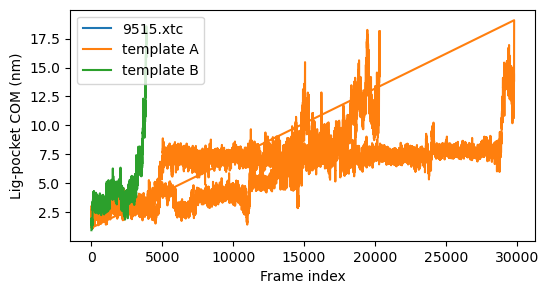

In [24]:
def plot_com_series(frames, feats, label=None, ax=None):
    """
    Plot ligand-pocket COM distance vs frame index.
    
    Parameters:
    -----------
    frames : array, frame indices (0-based)
    feats : array (T x F), feature matrix where first column is COM distance
    label : str, optional label for the plot
    ax : matplotlib axis, optional existing axis to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(frames, feats[:,0], label=label)
    ax.set_xlabel('Frame index')
    ax.set_ylabel('Lig-pocket COM (nm)')
    return ax

# Example: plot first file and templates (if available)
# Since files are now processed in batches, we find an example file to plot
if 'stitched_dir' in globals():
    # Find first XTC file in any subdirectory
    example_files = []
    for subdir in stitched_dir.iterdir():
        if subdir.is_dir():
            example_files.extend(list(subdir.glob('*.xtc')))
            if example_files:
                break
    
    if example_files:
        f = example_files[0]
        u = mda.Universe(topology, str(f))
        frames, feats = extract_features(u, 
                                         pathway_A_resids=pathway_A_residues,
                                         pathway_B_resids=pathway_B_residues)
        ax = plot_com_series(frames, feats, label=f.name)
        if 'tA_feats' in globals():
            plot_com_series(tA_times, tA_feats, label='template A', ax=ax)
        if 'tB_feats' in globals():
            plot_com_series(tB_times, tB_feats, label='template B', ax=ax)
        ax.legend()
        plt.show()
    else:
        print("No XTC files found for plotting example")
else:
    print("Please run the classification cell first to set stitched_dir")

## 9) Notes, pitfalls and next steps
- DTW is robust to speed differences but will still be affected by severe undersampling; consider interpolation when templates are much denser.
- Standardize features before comparing to reduce units effect.
- Tune `contact_cutoff` and DTW `window` for your system; start with small values and inspect results visually.
- If you have many segments and performance becomes an issue, compute a low-dimensional projection (PCA) of features and run DTW on the first 2-3 components.
- Validate classification by visual inspection on a small labeled subset, or by cross-checking with committor/other physical markers if available.